# Advanced Lane Tracking: Pipeline Development
## Introduction
This notebook develops and test the pipeline to detect and track lane lines within videos of road driving. The video frames use the camera calibration and distortion correction information conducted in the 'Camera Calibration and Detection' notebook, which are saved as a pickle file and loaded.

An example image from a video feed is shown below.

![Example Road Image](./test_images/test5.jpg)
    
The pipeline is implemented in the following steps:
* Camera calibration matrix and distortion coefficients are estimated from a set of chessboard images at multiple perspectives. This is performed at initialization, and the calibration/distortion is assumed to hold for all further tests.
* Video feed is processed 'per frame' with:
    * Distortion correction is enable raw images.
    * Color space conversion and computer vision processing, such as thresholding and gradient estimation, are used to generate a thresholded binary image.
    * The binary image is transformed to a "birds-eye view" with a perspective transform.
    * Histogram and window/convolution operations are applied to detect lane pixels and to estimate the lane.
    * Lane curvature and vehicle position are estimated.
    * Lane estimates are re-projected into the original image for visualization.
* The final video displays the lane boundaries and provides the numerical estimation of lane curvature and vehicle position.



In [374]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import os
import pickle
import laneRender
import sobelGradient

In [375]:
# Define a class to receive the characteristics of each line detection
class Line():
    navg = 10
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = 0     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = 0  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #polynomial coefficients for the most recent n iterations
        self.previous_fits = [np.array([False])] 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        
        # RoC Calibration
        mx = 1
        my = 1
        
    def getBestFit(self):
        ploty = np.linspace(0,760-1, 760)
        fitsx = []
        fitsy = []
        for fit in self.previous_fits:
            if any(fit != False):
                fitx = np.polyval(fit,ploty)
                fitsx.extend(fitx)
                fitsy.extend(ploty)
        self.best_fit = np.polyfit(fitsy,fitsx, deg = 2)
        
    def addLine(self,fit,ptsx, ptsy):
        # Save old fit for stats
        if len(self.previous_fits) >= self.navg:
            self.previous_fits.pop(-1)
        if self.current_fit[0]:
            self.previous_fits.insert(0,self.current_fit)
        
        # Estimate Best fit
        if len(self.previous_fits) >= 5:
            self.getBestFit()
            self.detected = True
        else:
            self.best_fit = self.current_fit[0]
        
        # Add line fit
        self.allx = ptsx
        self.ally = ptsy
        self.diffs = self.current_fit - fit
        self.current_fit = fit
        
        # update
        self.calcRoC()
        self.calcOffset()
        
    def calcOffset(self):
        # Calculate the line_base_pos from the curret fit parameters
        self.line_base_pos = np.polyval(self.current_fit,760)
        if len(self.recent_xfitted) >= self.navg:
            self.recent_xfitted.pop()
            
        self.recent_xfitted.insert(0,self.line_base_pos)
        self.bestx = self.mx*np.mean(self.recent_xfitted)
        
    def calcRoC(self):
        # Calculate the radius of curvature from the curret fit parameters
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(760)

        ##### Implement the calculation of R_curve (radius of curvature) #####
        roc = (1+(2*(self.mx/self.my**2)self.current_fit[0]*y_eval+(self.mx/self.my)*self.current_fit[1])**2)**(3/2)/np.abs(2*(self.mx/self.my**2)*self.current_fit[0])
        self.radius_of_curvature =  roc
        


SyntaxError: invalid syntax (<ipython-input-375-0f5848531703>, line 84)

In [448]:
class LineDetectPipeline:
    mtx = None
    dist = None
    lane_col = [0,1,0]
    
    kernel_size = (5,5)
    kernel_sigma_x = 0.1
    kernel_sigma_y = 1
    
    # Acumulator
    bev_grey_accum = None
    accum = False
    
    # Color Space Thresholds
    S_THRESH = (150,255)
    L_THRESH = (200,255)
    
    # Sobel Gradient Threshold    
    sobel_x_thresh = (25,255)
    sobel_x_kernel = 15
    sobel_mag_thresh = (50,255)#50
    sobel_mag_kernel = 15
    sobel_dir_thresh = (0,np.pi/6)
    sobel_dir_kernel = 21
    
    # binary Threshold
    bin_threshold = 40
    
    # shadow detection
    shadow_threshold = 60
    
    # Lane Fitting
    lane_estimate_stable = []
    left_lane_fit = []
    right_lane_fit = []
    
    # Lane Fitting HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 30
    
    left_lane = Line()
    right_lane = Line()
    
    def __init__(self):
        # Initialization
        self.loadCameraCal()
        self.loadPerspectiveTsfm()
        
        # Set Line RoC Calibration
        self.left_lane.mx = 3.5/(1000-280)
        self.left_lane.my = 35/(760)
        self.right_lane.mx = 3.5/(1000-280)
        self.right_lane.my = 35/(760)
        
    def loadCameraCal(self):
        # Load the Camera Calibration
        try:
            [self.mtx,self.dist] = pickle.load(open("camera_calibration.p", 'rb'))
            return 1
        except:
            return 0
        
    def loadPerspectiveTsfm(self):
        # Load the Birds-Eye View Perspective Transform
        try:
            [self.M,self.Minv] = pickle.load(open("camera_bev_perspective.p", 'rb'))
            return 1
        except:
            return 0
        
    def applyCalibration(self,image):
        # Apply the Camera Calibration to undistort the image.
        return cv2.undistort(image, self.mtx, self.dist, None, self.mtx)
        
    def applyPerspective(self,image, direction = 'forward'):
        # Apply the forward or backward perspective transform.
        # Image is assumed to be grayscale.
        img_size = image.shape
        
        if direction == 'forward':
            return cv2.warpPerspective(image, self.M, dsize = img_size[1::-1], flags=cv2.INTER_LINEAR)
        elif direction == 'backward':
            return cv2.warpPerspective(image, self.Minv, dsize = img_size[1::-1], flags=cv2.INTER_LINEAR)
        
    def thresholdImage(self, image):
        # Apply Color Space Thresholding to assist Lane identification.
        l_image = self.hlsSelectGrey(image,self.L_THRESH, chan = 1)
        s_image = self.hlsSelectGrey(image,self.S_THRESH, chan = 2)
        
        # Apply Vertical bluss
        out_grey = laneRender.weighted_img(l_image,s_image,1., 1.)
        return out_grey
    
    def applyGreyThreshold(self, image):
        # Suppress all pixels below the 'grey' threshold
        pixels = image < self.bin_threshold
        bin_image = image.copy()
        bin_image[pixels] =0
        return bin_image
    
    def hlsSelectGrey(self,image, thresh=(0, 255), chan = 2, inv = False):
        # Threshold an BGR image using HLS
        # 1) Convert to HLS color space
        img_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
        # 2) Apply a threshold to the Selected channel
        img_channel = img_hls[:,:,chan]
        
        # Threshold pixels
        thresh_index = (img_channel >= thresh[0]) & (img_channel <= thresh[1])

        img_thresh = np.zeros_like(img_channel)
        img_thresh[thresh_index] = img_channel[thresh_index]
        # 3) Return a binary image of threshold result
        maxVal = np.amax(img_thresh)
        img_thresh = np.int16(255*np.float32(img_thresh)/maxVal)
        if inv:
            img_thresh = 255 - img_thresh
        return img_thresh
    
    def getLines(self, grey):
        # Select Pixels based upon Sobel gradient filter thresholding in:
        # the X Direction, Abs. Gradient Magnitude, and Angle spaces.
        x_thresh = sobelGradient.sobel_abs_thresh(grey, orient = 'x', \
                                                  thresh = self.sobel_x_thresh,\
                                                 sobel_kernel = self.sobel_x_kernel)
#         abs_thresh = sobelGradient.sobel_mag_thresh(grey, self.sobel_mag_thresh,\
#                                                  sobel_kernel = self.sobel_mag_kernel)
#         dir_thresh = sobelGradient.sobel_dir_thresh(grey, self.sobel_dir_thresh,\
#                                                  sobel_kernel = self.sobel_dir_kernel)
        # Numerical AND
        sum_thresh = x_thresh 
        maxVal = np.amax(sum_thresh)
        minVal = np.amin(sum_thresh)
        sum_thresh = np.int16(255*np.float32(sum_thresh)/maxVal)
        return sum_thresh
    
    def detectLanesBEV(self, bev_image):
        # Detect Lane Lines in Birds-Eye View Perspective Images.
        # Returns an image with the lane lines identified.        

        #Search for Initial conditions
        leftx, lefty, leftv, rightx, righty, rightv, out_img = self.windowSearch(bev_image)
            
        # Fit polynomial to the left and right
        out_img, fit_left, res_left = self.fit_polynomial(out_img, leftx, lefty,\
                                                          leftv,\
                                                          color = [255.,0,0])
        

        out_img, fit_right, res_right = self.fit_polynomial(out_img, rightx, righty,\
                                                            rightv,\
                                                            color = [0, 255.,0])
        
        # TODO: Line Sanity Check
        # - Checking that they have similar curvature
        # - Checking that they are separated by approximately the right distance horizontally
        # - Checking that they are roughly parallel
        
        self.left_lane.addLine(fit_left,leftx, lefty)
        self.right_lane.addLine(fit_right,rightx, righty)
        
        # Write Polygon
        out_img_poly = np.zeros_like(out_img)
        
        if self.left_lane.detected & self.right_lane.detected:
            out_img_poly = self.plotPoly(out_img_poly,[self.left_lane.best_fit,self.right_lane.best_fit])
        else:
            out_img_poly = self.plotPoly(out_img_poly,[self.left_lane.current_fit,self.right_lane.current_fit])
        out_img = laneRender.weighted_img(out_img_poly,out_img,1,0.4)
        
        return np.float32(out_img)
        
    def plotPoly(self, image, polys):
        # Plot the polynomial onto the image.
        out_vals = []
        ipoly = 0
        for poly in polys:
            
            # Generate x and y values for plotting
            
            if ipoly == 1:
                ploty = np.linspace(image.shape[0]-1, 0, image.shape[0] )
            else:
                ploty = np.linspace(0, image.shape[0]-1, image.shape[0] )
            try:
                val_fitx = poly[0]*ploty**2 + poly[1]*ploty + poly[2]
            except TypeError:
                # Avoids an error if `left` and `right_fit` are still none or incorrect
                print('The function failed to fit a line!')
                val_fitx = 1*ploty**2 + 1*ploty
            ipoly += 1
            
#             out_vals.append(np.array([np.int32([x,y]) for x,y in zip(val_fitx, ploty)]))
            out_vals.extend([[x,y] for x,y in zip(val_fitx, ploty)])
        
        cv2.fillPoly(image, np.int32([out_vals]),\
                       color = [0,255.,255.])
#         cv2.polylines(image, np.int32([out_vals]),\
#                    isClosed = True,\
#                    color = [0,255.,255.],\
#                    thickness = 5)
        return image
    
    
    def fit_polynomial(self,lane_image, xvals, yvals, ivals, color = [255,0,0]):
        ### Fit a second order polynomial to each using `np.polyfit` ###
#         weights = np.multiply(np.sqrt(ivals/255.),\
#                               np.exp(-(lane_image.shape[0] - yvals)/(lane_image.shape[0])))
        weights = ivals/255
        
        
        # Fit Polynomial
        val_fit, residuals, rank, singular_values, rcond =  np.polyfit(yvals, xvals, deg = 2, w = weights, full = True)

        ## Visualization ##
        # Colors in the left and right lane regions
        lane_image[yvals, xvals] = color
        return lane_image, val_fit, residuals    
    
    def polynomialSearch(self, bev_image):
        # Search for lane lines around an initial polynomial estimate.
        
        # Threshold
        out_img_grey = self.applyGreyThreshold(bev_image)
        
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((out_img_grey, out_img_grey, out_img_grey))
        
        # Grt Non-zero pixels
        nonzero = out_img_grey.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Calculate polynomial values
        #Left
        left_lane_fit = np.polyval(self.left_lane.current_fit, nonzeroy)
        left_lane_win_min = left_lane_fit - self.margin
        left_lane_win_max = left_lane_fit + self.margin
        
        #Right
        right_lane_fit = np.polyval(self.right_lane.current_fit, nonzeroy)
        right_lane_win_min = right_lane_fit - self.margin
        right_lane_win_max = right_lane_fit + self.margin
        
        # Select Pixels within boundary
        win_nonzerox_left = (nonzerox >= left_lane_win_min) & (nonzerox <= left_lane_win_max)
        win_nonzerox_right = (nonzerox >= right_lane_win_min) & (nonzerox <= right_lane_win_max)
        
        # Save vals
        good_left_inds = win_nonzerox_left.nonzero()[0]
        good_right_inds = win_nonzerox_right.nonzero()[0]
        good_left_vals = 1./255*out_img_grey[nonzeroy[good_left_inds],\
                                   nonzerox[good_left_inds]]
        good_right_vals = 1./255*out_img_grey[nonzeroy[good_right_inds],\
                                    nonzerox[good_right_inds]]        
        
        # Append these indices to the lists
        left_lane_inds = []
        right_lane_inds = []
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        leftv = out_img_grey[nonzeroy[left_lane_inds],\
                            nonzerox[left_lane_inds]]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        rightv = out_img_grey[nonzeroy[right_lane_inds],\
                            nonzerox[right_lane_inds]]
        return leftx, lefty, leftv, rightx, righty, rightv, out_img
    
    def windowSearch(self, bev_image):
        # Window Search for lane locations
        
        # Threshold
        out_img_grey = self.applyGreyThreshold(bev_image)
        
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((out_img_grey, out_img_grey, out_img_grey))
        
        # Take a histogram of the bottom third of the BEV image
        bev_histogram = np.sum(out_img_grey[out_img_grey.shape[0]//2:,:],\
                                   axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(bev_histogram.shape[0]//2)
        leftx_base = np.argmax(bev_histogram[100:midpoint]) + 100
        rightx_base = np.argmax(bev_histogram[midpoint:bev_histogram.shape[0]-100]) + midpoint
        
        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(out_img_grey.shape[0]//self.nwindows)
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = out_img_grey.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(self.nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = bev_image.shape[0] - (window+1)*window_height
            win_y_high = bev_image.shape[0] - window*window_height

            # Window Boundaries
            win_xleft_low = leftx_current - self.margin
            win_xleft_high = leftx_current + self.margin
            win_xright_low = rightx_current - self.margin
            win_xright_high = rightx_current + self.margin

            # Identify the nonzero pixels in x and y within the window
            win_nonzerox_left = (nonzerox >= win_xleft_low) & (nonzerox <= win_xleft_high)
            win_nonzerox_right = (nonzerox >= win_xright_low) & (nonzerox <= win_xright_high)
            win_nonzeroy = (nonzeroy >= win_y_low) & (nonzeroy <= win_y_high)
            
            good_left_inds = (win_nonzerox_left & win_nonzeroy).nonzero()[0]
            good_right_inds = (win_nonzerox_right & win_nonzeroy).nonzero()[0]
            good_left_vals = 1./255*out_img_grey[nonzeroy[good_left_inds],\
                                       nonzerox[good_left_inds]]
            good_right_vals = 1./255*out_img_grey[nonzeroy[good_right_inds],\
                                        nonzerox[good_right_inds]]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            ### If found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if np.sum(good_left_vals) >= self.minpix:
                # leftx_current = np.mean(nonzerox[good_left_inds], dtype = np.int32)
                leftx_current = np.int32(np.divide(np.sum(np.multiply(nonzerox[good_left_inds],good_left_vals)),\
                                         np.sum(good_left_vals)))
            
            if np.sum(good_right_vals) >= self.minpix:
                # rightx_current = np.mean(nonzerox[good_right_inds], dtype = np.int32)
                rightx_current = np.int32(np.divide(np.sum(np.multiply(nonzerox[good_right_inds],good_right_vals)),\
                                         np.sum(good_right_vals)))
        
        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        leftv = out_img_grey[nonzeroy[left_lane_inds],\
                            nonzerox[left_lane_inds]]
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        rightv = out_img_grey[nonzeroy[right_lane_inds],\
                            nonzerox[right_lane_inds]]
        return leftx, lefty, leftv, rightx, righty, rightv, out_img

    def selectROI(self, image):
        img_size = image.shape
        LL = [150, img_size[0]-50]
        LR = [1250, img_size[0]-50]
        UL = [500, img_size[0]//2+50]
        UR = [715, img_size[0]//2+50]
        dst_corners = np.int32(np.array([LL,UL,UR,LR]))
        return laneRender.region_of_interest(image, np.int32([dst_corners]))        
    
    def colorImage(self, grey, color = [0.,1.,0.]):
        # Normalize input
        max_val = np.amax(grey)
        grey_norm = 255*np.float32(grey)/max_val
        return np.int16(np.dstack((color[0]*grey,\
                                color[1]*grey,
                                color[2]*grey)));
    def maskShadow(self, frame):
        # Mask all pixels below the 'shadow' greyscale threshold
        if len(frame.shape) > 2:
            frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        pixels = frame < self.shadow_threshold
        showdowmask = np.zeros_like(frame)
        showdowmask[pixels] = 1
        return showdowmask
        
    def procFrame(self, frame):
        # Process image frame.
        
        # Process the current image frame
        frame_blurr= cv2.GaussianBlur(frame,\
                                     self.kernel_size,\
                                     sigmaX = self.kernel_sigma_x,\
                                     sigmaY = self.kernel_sigma_y)
        # Undistort
        cal_frame = self.applyCalibration(frame_blurr)
        
        # Grayscale Conversion
        frame_grey = self.thresholdImage(cal_frame)
        
        # Detect and Suppress Shadows 
        shadow_mask = self.maskShadow(cal_frame)
        frame_grey[shadow_mask == 1] = 0;
        
        # Apply BEV Perspective
        bev_image = self.applyPerspective(frame_grey, direction = 'forward')
        
        # Accumulation
        if self.accum:
            if self.bev_grey_accum is None:
                self.bev_grey_accum = bev_image
            else:
                self.bev_grey_accum = laneRender.weighted_img(bev_image,self.bev_grey_accum, 0.1, 1.)
                bev_image = self.bev_grey_accum
        
         # Gradient Detection
        grey_lines = self.normalizeImage(self.getLines(bev_image))
        
        # Detect Lanes
        lane_detects = self.detectLanesBEV(grey_lines)
    
        # Project lanes onto calibrated image
        lane_image = self.applyPerspective(lane_detects, direction = 'backward')
        
        # Overlay lanes onto Frame
        lane_image = self.normalizeImage(lane_image)
        
        lane_image = laneRender.weighted_img(lane_image, np.int32(cal_frame), α=0.8,β=1)
        
        # Add State Information:
        # - Calculate Lane Position
        # - Calculate lane Radius of Curvature
        
        lane_image_text = self.writeState(lane_image)
        
        return lane_image_text
    
    def writeState(self, image):
        # Write the State Estimate
        statefont = cv2.FONT_HERSHEY_PLAIN
        stateScale = 4
        stateColor = [0,0,0]
        stateThick = 5
        
        right_roc = self.right_lane.radius_of_curvature
        cv2.putText(image, 'Right Radius: %d m'%(right_roc),\
                    org = (50, 225), fontFace = statefont,\
                    fontScale = stateScale, color = stateColor,\
                    thickness = stateThick)
        # Left Lane
        left_roc = self.left_lane.radius_of_curvature
        cv2.putText(image, 'Left Radius: %d m'%(left_roc),\
                    org = (50,150), fontFace = statefont,\
                    fontScale =  stateScale, color = stateColor,\
                    thickness = stateThick)
        
       
        lane_offset =  (1280./2 - np.mean([self.right_lane.bestx,self.left_lane.bestx]))*self.left_lane.mx
        cv2.putText(image, 'Offset: %2.2f m'%(lane_offset),\
                    org = (50,75), fontFace = statefont,\
                    fontScale =  stateScale, color = stateColor,\
                    thickness = stateThick)
        return image
            
    def normalizeImage(self, image, maxVal = 255):
        # noramlize image to maxVal
        imgMaxVal = np.amax(image)
        return np.int32(maxVal*(np.float32(image)/imgMaxVal))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


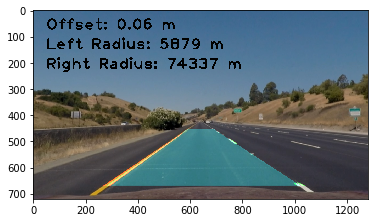

In [449]:
P = LineDetectPipeline()


# Get Test Frame to debug pipeline
images = ['straight_lines1.jpg','straight_lines2.jpg',\
          'test1.jpg','test2.jpg','test3.jpg',
          'test4.jpg','test5.jpg','test6.jpg']
%matplotlib inline
nrep = 4
for img in images[:1]:
    frame = mpimg.imread('./test_images/' + img)
    for i in range(nrep):
        img_out = P.procFrame(frame)
#     plt.subplot(1,2,1)
    plt.imshow(frame)
#     plt.subplot(1,2,2)

    plt.imshow(img_out)
#     plt.show()

# Image Thresholding
Test processing on video sequence.


In [370]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [371]:
# Function to sub-sample an image file
class movieSampler:
    # Movie Sampler class for saving images from a movie file.
    frames = [] # saved frames
    sample_rate = 20 # spacing between sampled frames
    frame_count = 0 # number of saved frames
    max_frames = 20 # max number of saved frames
        
    def sampleFrame(self, image):
        self.frame_count += 1
        if not len(self.frames) >= self.max_frames:
            if self.frame_count%self.sample_rate == 0:
                self.frames.append(image)
        return image

    def reset(self):
        self.frames = []
        self.frame_count = 0
mvSamp1 = movieSampler()
mvSamp1.reset()

In [372]:
# Callback
Pnew = LineDetectPipeline()

def process_image(image):
    # Callback function to process the video
    Pnew.accum = False
    result = Pnew.procFrame(image)
    return result

# Testing
cases = [1]
subclip = False
clip_start = 0
clip_len = 15

for case in cases:
    if case == 1:
        output_file = 'test_videos_output/project_video.mp4'
        if subclip:
            clip1 = VideoFileClip("./project_video.mp4").subclip(clip_start,clip_start+clip_len)
        else:
            clip1 = VideoFileClip("./project_video.mp4")
    elif case == 2:
        output_file = 'test_videos_output/challenge_video.mp4'
        if subclip:
            clip1 = VideoFileClip("./challenge_video.mp4").subclip(clip_start,clip_start+clip_len)
        else:
            clip1 = VideoFileClip("./challenge_video.mp4")
    elif case == 3:
        output_file = 'test_videos_output/harder_challenge_video.mp4'
        if subclip:
            clip1 = VideoFileClip("./harder_challenge_video.mp4").subclip(clip_start,clip_start+clip_len)
        else:
            clip1 = VideoFileClip("./harder_challenge_video.mp4")

    out_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
    %time out_clip.write_videofile(output_file, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge_video.mp4
[MoviePy] Writing video test_videos_output/challenge_video.mp4



 83%|████████▎ | 374/450 [00:56<00:11,  6.64it/s]


100%|██████████| 450/450 [01:08<00:00,  6.61it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge_video.mp4 

CPU times: user 35.9 s, sys: 3.18 s, total: 39.1 s
Wall time: 1min 11s


In [453]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file))

In [452]:
output_file = 'test_videos_output/project_video.mp4'